In [1]:
class PathAll(object):
    # 停用词
    stopWordList = "./stopwords/hit_stopwords.txt"
    # 词向量路径
    word2vec="../sgns.weibo.bigram-char/sgns.weibo.bigram-char"
    # 训练文本
    dataSource = "./data/2class/reviews_wuhan_labeled_plus.csv"
    # 模型保存路径
    model_save="./model_save/ABiLSTM_Att.weibo300.wuhan_labeled_plus.3/AdLSTM_Att"

# 词向量的维数
Embedding_size=300
   

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\86134\AppData\Local\Temp\jieba.cache
Loading model cost 0.843 seconds.
Prefix dict has been built successfully.


the max length 477
sequence length: 87


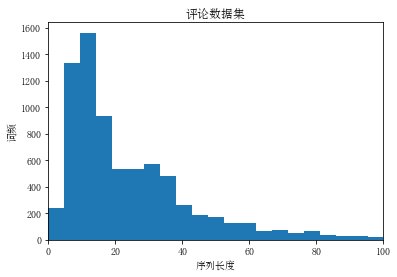

the proportion of length 0.965


In [2]:
from tools import seqLength
##实例化
seqLen=seqLength(PathAll.dataSource,PathAll.stopWordList)
sequenceLen=seqLen.seq_len()

print("sequence length:",sequenceLen)
seqLen.plot_seqence()


In [3]:
from config import Config
# 实例化配置参数对象
config = Config(sequenceLen,Embedding_size)
config.rate=0.8
# 读取数据集对象到内存中
import dataSet
data = dataSet.Dataset(config,PathAll)
data.dataGen()

In [4]:
print("train data shape: {}".format(data.trainReviews.shape))
print("train label shape: {}".format(data.trainLabels.shape))
print("test data shape: {}".format(data.testReviews.shape))
print("test label shape: {}".format(data.testLabels.shape))

train data shape: (6083, 87)
train label shape: (6083, 1)
test data shape: (1521, 87)
test label shape: (1521, 1)


In [5]:
from model import ABiLSTM_2class
import tools
import datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import tensorflow.compat.v1 as tf

In [6]:
##定义损失存储list
tra_losses = []
tra_accs = []
tra_aucs = []
tra_precisions = []
tra_recalls = []
tra_Fs=[]
tra_preValue=[] # 训练集预测的分类值

test_losses = []
test_accs = []
test_aucs = []
test_precisions = []
test_recalls = []
test_Fs=[]
test_preValue=[] # 测试集预测的分类值
# 定义计算图
with tf.Graph().as_default():
    sess=tf.Session()
    # 定义会话
    with sess.as_default():
        lstm = ABiLSTM_2class(config, data.wordEmbedding, data.indexFreqs)
        
        globalStep = tf.Variable(0, name="globalStep", trainable=False)
        # learningRate = config.training._AdaptiveLearningRate(0.01,globalStep,100,0.9)
        learningRate = config.training.learningRate
        optimizer = tf.train.AdamOptimizer(learningRate)
        trainOp = optimizer.minimize(lstm.loss,global_step=globalStep)
   
        # 初始化所有变量
        # saver = tf.train.Saver(tf.global_variables(), max_to_keep=5)
        sess.run(tf.global_variables_initializer())

        def trainStep(batchX, batchY):
            """
            训练函数
            """   
            feed_dict = {
              lstm.inputX: batchX,
              lstm.inputY: batchY,
              lstm.dropoutKeepProb: config.model.dropoutKeepProb
            }
            _,step, loss, predictions, binaryPreds = sess.run(
                [trainOp, globalStep, lstm.loss, lstm.predictions, lstm.binaryPreds],
                feed_dict)

            tra_preValue.append(binaryPreds)
            acc, precision, recall, F = tools.genMetrics(batchY, predictions, binaryPreds)
            tra_losses.append(loss)
            tra_accs.append(acc)
            tra_precisions.append(precision)
            tra_recalls.append(recall)
            tra_Fs.append(F)
            
            return loss, acc, precision, recall,F

        def testStep(batchX, batchY):
            """
            验证函数
            """
            feed_dict = {
              lstm.inputX: batchX,
              lstm.inputY: batchY,
              lstm.dropoutKeepProb: config.model.dropoutKeepProb
            }
            step, loss, predictions, binaryPreds = sess.run(
                [globalStep, lstm.loss, lstm.predictions, lstm.binaryPreds],
                feed_dict)
            
            test_preValue.append(binaryPreds)
            acc, precision, recall,F = tools.genMetrics(batchY, predictions, binaryPreds)
            test_losses.append(loss)
            test_accs.append(acc)
            test_precisions.append(precision)
            test_recalls.append(recall)
            test_Fs.append(F)

            return loss, acc, precision, recall,F
        
        ##在精度评定是每个epoches评定一次
        for i in range(config.training.epoches):
            tlosses = []
            taccs = []
            taucs = []
            tprecisions = []
            trecalls = []
            tFs=[]
            tPreValue=[]
            # 训练模型
            print("epoches:",i)
            for batchTrain in tools.nextBatch(data.trainReviews, data.trainLabels, config.batchSize):
                
                tloss, tacc,tprecision, trecall,tF = trainStep(batchTrain[0], batchTrain[1])
                tlosses.append(tloss)
                taccs.append(tacc)
                tprecisions.append(tprecision)
                trecalls.append(trecall)
                tFs.append(tF)
                
                # 定义在这里其实就是让在每个epoches中各个评价指标取平均得到最终的结果
                vlosses = []
                vaccs = []
                vaucs = []
                vprecisions = []
                vrecalls = []
                vFs=[]
                # 获取ISO格式的时间格式：'2019-04-25T16:59:27.587264'
                timeStr = datetime.datetime.now().isoformat()
                currentStep = tf.train.global_step(sess, globalStep) 

                 #打印出每个epoches的精度指标
                if currentStep % int(np.floor(data.trainReviews.shape[0]//config.batchSize))==0:
                    #保存模型，每个epoch保存一下
                    tf.train.Saver().save(sess,PathAll.model_save+'_epoch_'+str(i))
                    
                    print(">>>Train Evaluation:")
                    print("{}, step: {}, loss: {}, acc: {}, recall: {},F1:{}".format(timeStr, currentStep, tools.mean(tlosses), 
                                                                                                       tools.mean(taccs),tools.mean(trecalls),tools.mean(tFs)))
                    print("\n>>>Test Evaluation:")

                    for batchEval in tools.nextBatch(data.testReviews, data.testLabels, config.batchSize):
                        
                        vloss, vacc, vprecision, vrecall ,vF =testStep(batchEval[0], batchEval[1])
                        vlosses.append(vloss)
                        vaccs.append(vacc)
                        vprecisions.append(vprecision)
                        vrecalls.append(vrecall)
                        vFs.append(vF)
                    time_str = datetime.datetime.now().isoformat()
                    #打印出每个batchsize中的精度评价指标
                    print("{}, step: {}, loss: {}, acc: {}, recall: {}, F1:{}".format(time_str, currentStep, tools.mean(vlosses), 
                                                                                                       tools.mean(vaccs),tools.mean(vrecalls),tools.mean(vFs)))
                    
        print("End of training model")

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoches: 0
>>>Train Evaluation:
2022-05-31T21:54:01.474851, step: 47, loss: 1.401124134976813, acc: 0.4842212765957447, recall: 0.4842212765957447,F1:0.5012361702127661

>>>Test Evaluation:
2022-05-31T21:54:25.886721, step: 47, loss: 1.3091670924966985, acc: 0.44887272727272726, recall: 0.44887272727272726, F1:0.4879818181818182
epoches: 1


KeyboardInterrupt: 

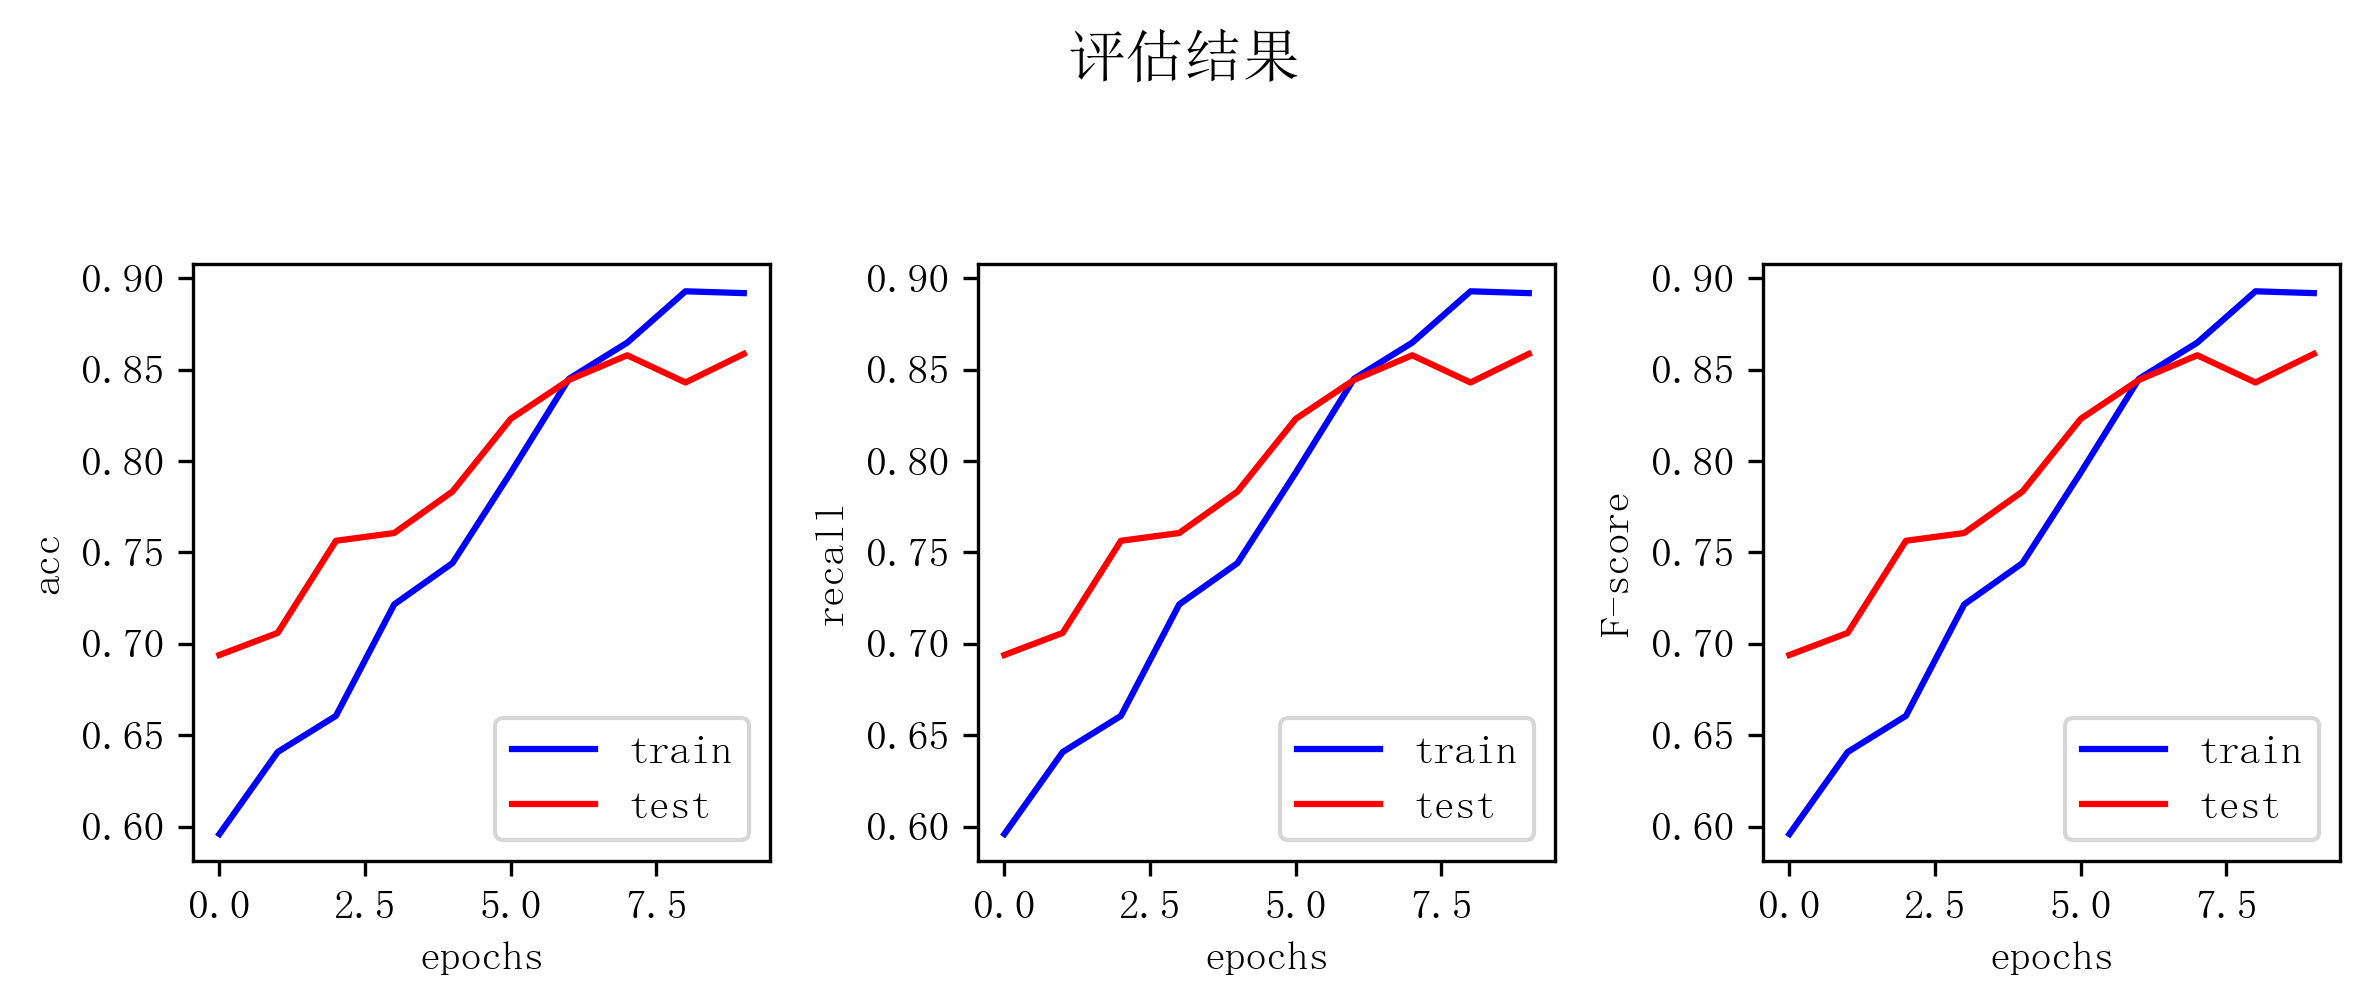

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimSun']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

##绘制精度曲线
def avg_acc(dataLength,acc,batchSize,epoches):
    ##看能分为多少个batch
    accs=[]
    numBatches = dataLength // batchSize
    numBatches= int(np.floor(numBatches))
    for i in range(epoches):
        start = i * numBatches
        end = start + numBatches
        temp_acc = np.mean(acc[start: end])
        accs.append(temp_acc)
    return accs
Train_accs=avg_acc(data.trainReviews.shape[0],tra_accs,config.batchSize,config.training.epoches)
Test_accs=avg_acc(data.testReviews.shape[0],test_accs,config.batchSize,config.training.epoches)
Train_recalls=avg_acc(data.trainReviews.shape[0],tra_recalls,config.batchSize,config.training.epoches)
Test_recalls=avg_acc(data.testReviews.shape[0],test_recalls,config.batchSize,config.training.epoches)
Train_Fs=avg_acc(data.trainReviews.shape[0],tra_Fs,config.batchSize,config.training.epoches)
Test_Fs=avg_acc(data.testReviews.shape[0],test_Fs,config.batchSize,config.training.epoches)
epochs= range(config.training.epoches)

Train_losses=avg_acc(data.trainReviews.shape[0],tra_losses,config.batchSize,config.training.epoches)
Test_losses=avg_acc(data.testReviews.shape[0],test_losses,config.batchSize,config.training.epoches)
plt.figure(dpi=300,figsize=(8,3))
plt.suptitle('损失值', fontsize=14, y=1.1)
plt.plot(epochs,Train_losses,'b', label='train')
plt.plot(epochs,Test_losses, 'r', label= 'test')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right',prop={'style': 'italic',})
plt.show()

plt.figure(dpi=300,figsize=(8,3))
plt.suptitle('评估结果', fontsize=14, y=1.1)
plt.rcParams['font.sans-serif']=['SimSun'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False   #用来正常显示负号
plt.rcParams['axes.titlepad'] = 20
plt.subplot(1,3,1)
plt.plot(epochs,Train_accs,'b', label='train')
plt.plot(epochs,Test_accs, 'r', label= 'test')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(loc='lower right',prop={'style': 'italic',})
plt.subplot(1,3,2)
plt.plot(epochs,Train_recalls,'b', label='train')
plt.plot(epochs,Test_recalls, 'r', label= 'test')
plt.xlabel('epochs')
plt.ylabel('recall')
plt.legend(loc='lower right',prop={'style': 'italic',})

plt.subplot(1,3,3)
plt.plot(epochs,Train_recalls,'b', label='train')
plt.plot(epochs,Test_recalls, 'r', label= 'test')
plt.xlabel('epochs')
plt.ylabel('F-score')
plt.legend(loc='lower right',prop={'style': 'italic',})
plt.tight_layout()
plt.show()
# plt.savefig('s.png')

In [ ]:
import pandas as pd
import numpy as np
#将每一个epoch中的精度取平均
Train_accs=avg_acc(data.trainReviews.shape[0],tra_accs,config.batchSize,config.training.epoches)
Test_accs=avg_acc(data.testReviews.shape[0],test_accs,config.batchSize,config.training.epoches)
Train_recalls=avg_acc(data.trainReviews.shape[0],tra_recalls,config.batchSize,config.training.epoches)
Test_recalls=avg_acc(data.testReviews.shape[0],test_recalls,config.batchSize,config.training.epoches)
Train_Fs=avg_acc(data.trainReviews.shape[0],tra_Fs,config.batchSize,config.training.epoches)
Test_Fs=avg_acc(data.testReviews.shape[0],test_Fs,config.batchSize,config.training.epoches)
Train_losses=avg_acc(data.trainReviews.shape[0],tra_losses,config.batchSize,config.training.epoches)
Test_losses=avg_acc(data.testReviews.shape[0],test_losses,config.batchSize,config.training.epoches)

df=pd.DataFrame()
df["test_accs"]=Test_accs
df["train_accs"]=Train_accs
df["test_recalls"]=Test_recalls
df["train_recalls"]=Train_recalls
df["test_Fs"]=Test_Fs
df["train_Fs"]=Train_Fs
df["test_losses"]=Test_losses
df["train_losses"]=Train_losses
print("mean_test_acc:",np.mean(df["test_accs"]))
print("mean_test_recall:",np.mean(df["test_recalls"]))
print("mean_test_Fs:",np.mean(df["test_Fs"]))
df

mean_test_acc: 0.7927600000000001
mean_test_recall: 0.7927600000000001
mean_test_Fs: 0.8108536363636363


,test_accs,test_recalls,test_Fs
0,0.693900,0.693900,0.737209
1,0.705982,0.705982,0.745082
2,0.756409,0.756409,0.784600
3,0.760664,0.760664,0.785536
4,0.783373,0.783373,0.803227
5,0.823136,0.823136,0.834009
6,0.844464,0.844464,0.848673
7,0.857936,0.857936,0.862264
8,0.843045,0.843045,0.847473
9,0.858691,0.858691,0.860464
